# Diffusion tensor model

The main limitation of the previously mentioned diffusion model is that it does not perform well in anisotropic areas of the brain since it does not take gradient direction into account and thus cannot estimate the direction of diffusion. The diffusion tensor model is a direct extension of the previous model to 3D. The implicit assumption of the DT model is that the dispersion pattern is a trivariate Gaussian. Therefore DT is proportional to the covariance matrix of the distribution. The positive-definitivness of DT ensures that the diffusivity will always be positive (negative diffusivity is meaningless).

Diffusion in the DT model is defined as a quadratic function of gradient direction:

$$d(\hat{q})=\hat{q}^{T}D\hat{q}$$

where $D$ is a symmetric positive-definite $3\times3$ tensor of parameters that need to estimated:

$$D=\begin{pmatrix}
D_{xx}&  D_{xy}& D_{xz}\\ 
D_{xy}&  D_{yy}& D_{yz}\\ 
D_{xz}&  D_{yz}& D_{zz}
\end{pmatrix}$$

Hence the DT model can be defined as:

$$S(b,\hat{q})=S(0,\mathbf{0})e^{-b\hat{q}^{T}D\hat{q}}$$

Now the model can be linearized:

$$logS(b,\hat{q})=logS(0,\mathbf{0})-b\hat{q}^{T}D\hat{q}$$

Finally the terms can be expanded:

$$logS(b,\hat{q})=logS(0,\mathbf{0}) - bq^{2}_{x}D_{xx} - 2bq_{x}q_{y}D_{xy} - 2bq_{x}q_{z}D_{xz} - bq_{y}^{2}D_{yy} - 2bq_{y}q_{z}D_{yz} - bq_{z}^{2}D_{zz}$$

where $q_x$, $q_y$ and $q_z$ are the $x$, $y$ and $z$ components of $\hat{q}$

This expansion can be used to establish a system of linear equations:

$$\begin{pmatrix}
logA(b_{1},\hat{q}_{1})\\ 
\vdots \\ 
logA(b_{n},\hat{q}_{n})
\end{pmatrix} = 
\begin{pmatrix}
1 & -b_{1}q^{2}_{1x} & -2b_{1}q_{1x}q_{1y} & -2b_{1}q_{1x}q_{1z} & -b_{1}q_{1y}^{2} & -2b_{1}q_{1y}q_{1z} &-b_{1}q_{1z}^{2}\\ 
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\ 
1 & -b_{n}q^{2}_{nx} & -2b_{n}q_{nx}q_{ny} & -2b_{n}q_{nx}q_{nz} & -b_{n}q_{ny}^{2} & -2b_{n}q_{ny}q_{nz} &-b_{n}q_{nz}^{2}
\end{pmatrix}
\begin{pmatrix}
logS(0,\mathbf{0})\\ 
D_{xx}\\ 
D_{xy}\\ 
D_{xz}\\ 
D_{yy}\\ 
D_{yz}\\ 
D_{zz}
\end{pmatrix}
$$

where $n$ is the number of measurements. This is again ordinary least squares problem which can be solved with Moore-Penrose pseudoinverse.

The elements of $D$ on the main diagonal show diffusivity in the $x$, $y$ and $z$ directions.

The figure below demonstrates that the DT model achieves significantly lower error in the anisotropic regions than the simple diffusion model:

![DIFFUSION_TENSOR_MODEL_PERFORMANCE](./figures/diffusion_tensor_model_performance.png)

Since DT modells diffusivity as a trivariate Gaussian the contours of diffusion are elipsoids. The contours are spherical in regions with isotropic diffusion. However anisotropic regions the contours become elipsoidal. The elipsoids can either be prolate (there is one dominant fibre direction) or oblate (two fibre bundles cross) The eigenvalues of $D$ describe the relative lengths of the elipsoid axes and the eigenvectors define the orientation of the axes:

![DIFFUSION_TENSOR_MODEL_CONTOURS](./figures/diffusion_tensor_contours.png)

![DIFFUSION_TENSOR_MODEL_CONTOURS_2](./figures/diffusion_tensor_contours_2.png)

Even though DT is not a particularly useful object by itself it can be used to derive important tissue characteristics like fractional anisotropy or mean diffusivity.

## Fractional anisotropy

Describes how much the DT deviates from isotropy and is defined as:

$$FA=\sqrt{\frac{3\sum_{i}^{}(\lambda_{i}-\frac{Tr(D)}{3})^{2}}{2\sum_{i}^{}\lambda_{i}^{2}}}$$

where

$$Tr(D)=D_{xx}+D_{yy}+D_{zz} = \lambda_{1} + \lambda_{2} + \lambda_{3}$$

The importance of FA is that it can highlight neurodegenerative deseases killing cells since isotropic regions emerge where anisotropy is expected.

## Mean diffusivity
Mean diffusivity describes the overall magnitude of diffusivity in a voxel and is defined as:

$$MD=\frac{Tr(D)}{3}$$

MD is also key in the diagnosis of neurodegenerative deseases since since as cells die barriers are removed and diffusivity increases. Furtermore tumors consist of densely packed small cells that conversely can decrease the overall diffusivity.

## DT limitations

Even though DT is more expressive that the simple diffusion model there are still scenarios that cannot be distinguished by the model. DT takes only the overall diffusivity into account thus as long as the overall diffusivity of a voxel remains unchanged the voxels will be undistinguishable for DT even though there are many fibre orientations that can achieve this overall diffusivity:

![DIFFUSION_TENSOR_MODEL_CONTOURS](./figures/equivalent_voxels.png)

## Implementation

In [6]:
import random
import scipy
import numpy as np
from matplotlib import pyplot as plt

from dataloader import loadhcp

In [2]:
# Load data
bvals, qhat, dwis = loadhcp.load_hcp()

In [3]:
# Define utility methods
def get_diff_tensor(p):
    return np.array([[p[1],p[2],p[3]],[p[2],p[4],p[5]],[p[3],p[5],p[6]]])

def display_array(arr, title=""):
    plt.imshow(np.flipud(arr.T), interpolation=None, cmap='gray')
    plt.title(title)
    plt.show()
    
def display_rgb_array(arr, title=""):
    plt.imshow(np.flipud(arr.transpose(1,0,2)), interpolation=None)
    plt.title(title)
    plt.show()

### Perform parameter estimation for a slice 72

In [4]:
param_map = np.zeros((145,174,7))

# Compute design matrix and pseudo-inverse
G = np.array([np.ones(len(bvals)), -bvals*(qhat[0,:]**2), -2*bvals*qhat[0,:]*qhat[1,:], -2*bvals*qhat[0,:]*qhat[2,:], -bvals*(qhat[1,:]**2), -2*bvals*qhat[1,:]*qhat[2,:], -bvals*(qhat[2,:]**2)]).T
G_inv = np.linalg.pinv(G)

# Estimate parameters for all voxels in slice 72
for i in range(145):
    for j in range(174):
        A = dwis[:,i,j,71]
        # Check whether any measurement is negative
        if np.min(A)>0:
            params = G_inv @ np.log(A)
            param_map[i,j] = params

### Compute mean diffusivity map

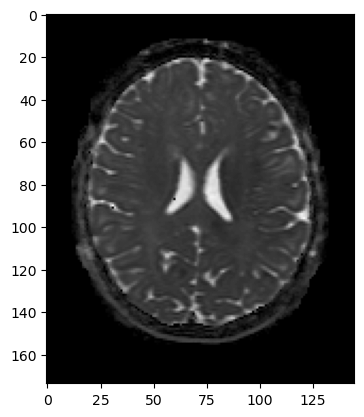

In [7]:
mean_diffusivity_map = np.zeros((145,174))

# Compute mean diffusivity for all voxels in slice 71
for i in range(145):
    for j in range(174):
        params = param_map[i,j]
        mean_diffusivity_map[i,j] = (params[1] + params[4] + params[6])/3

# Remove nagative values
mean_diffusivity_map[mean_diffusivity_map < 0] = 0

display_array(mean_diffusivity_map)

### Compute fractional anisotropy map

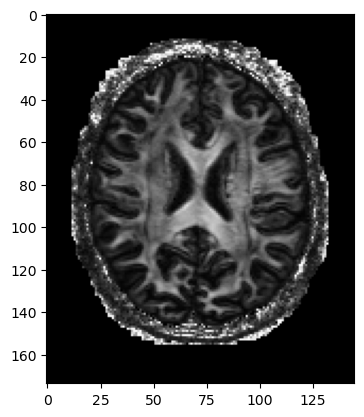

In [8]:
fractional_anisotropy_map = np.zeros((145,174))

# Compute fractional anisotropy for all voxels in slice 71
for i in range(145):
    for j in range(174):
        diffusion_tensor = get_diff_tensor(param_map[i,j])
        eig_vals, eig_vecs = np.linalg.eig(diffusion_tensor)
        # Prevent division by zero
        if(np.sum(eig_vals**2) != 0):
            fractional_anisotropy_map[i,j] = np.sqrt((1.5*np.sum((eig_vals - np.mean(eig_vals))**2))/np.sum(eig_vals**2))

display_array(fractional_anisotropy_map)

### Compute direction weighted map

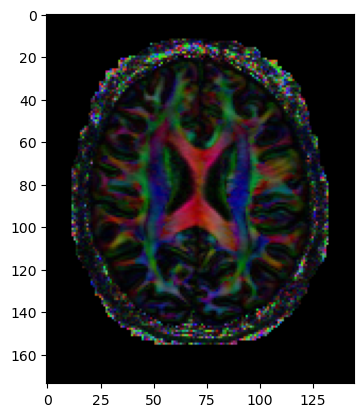

In [9]:
directional_colour_map = np.zeros((145,174,3))

# Compute directional colour encoding for all voxels in slice 71
for i in range(145):
    for j in range(174):
        diffusion_tensor = get_diff_tensor(param_map[i,j])
        eig_vals, eig_vecs = np.linalg.eig(diffusion_tensor)
        # Skip background voxels
        if(np.sum(eig_vals) != 0):
            max_eigval_index = np.argmax(eig_vals)
            max_eigvec = eig_vecs[:,max_eigval_index]
            directional_colour_map[i,j]=np.absolute(max_eigvec)*fractional_anisotropy_map[i,j]

# Normalize values to range[0,1]
directional_colour_map = (directional_colour_map - np.min(directional_colour_map)) / (np.max(directional_colour_map) - np.min(directional_colour_map))

display_rgb_array(directional_colour_map)